<a href="https://colab.research.google.com/github/Hitika-Jain/ParkInsight/blob/main/audio_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing Parkinson's patients: 100%|██████████| 6/6 [02:30<00:00, 25.05s/it]



🔄 Fold 1/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[984]	train's binary_logloss: 0.0249452	validation's binary_logloss: 0.129407

🔄 Fold 2/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[998]	train's binary_logloss: 0.0233073	validation's binary_logloss: 0.110159

🔄 Fold 3/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's binary_logloss: 0.0225031	validation's binary_logloss: 0.121639

🔄 Fold 4/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[942]	train's binary_logloss: 0.0243973	validation's binary_logloss: 0.19445

🔄 Fold 5/5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[894]	train's binary_logloss: 0.0287488	validation's binary_logloss: 0.110198

📊 Average Model Performance Ac

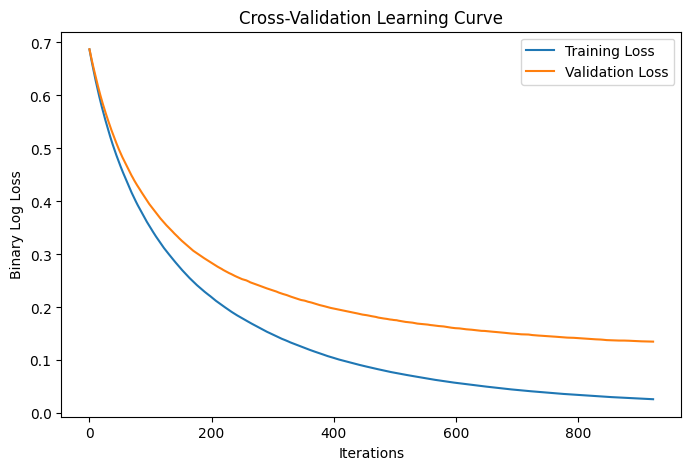

In [ ]:
import os
import librosa
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE  # If you need resampling
from tqdm import tqdm
# Dataset Path
dataset_path = "/content/drive/MyDrive/parkinson's audio dataset"

# Define categories
categories = {
    "15 Young Healthy Control": 0,
    "22 Elderly Healthy Control": 0,
    "28 People with Parkinson's disease": 1
}

# Function to extract MFCC features
def extract_mfcc(file_path, max_pad_len=100):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Pad/truncate to fixed size
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        return mfcc.flatten()  # Convert to 1D feature vector
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Data Collection
data, labels = [], []

for category, label in categories.items():
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue  # Skip files like "FILE CODES.xlsx"

    if category == "28 People with Parkinson's disease":  # Handling nested structure
        for group_folder in tqdm(os.listdir(category_path), desc="Processing Parkinson's patients"):
            group_path = os.path.join(category_path, group_folder)

            if not os.path.isdir(group_path):
                continue  # Skip any non-directory files

            for patient_folder in os.listdir(group_path):
                patient_path = os.path.join(group_path, patient_folder)

                if not os.path.isdir(patient_path):
                    continue  # Skip any non-directory files

                for file in os.listdir(patient_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(patient_path, file)
                        mfcc_features = extract_mfcc(file_path)

                        if mfcc_features is not None:
                            data.append(mfcc_features)
                            labels.append(label)

    else:  # Normal structure (Healthy Controls)
        for patient_folder in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            patient_path = os.path.join(category_path, patient_folder)

            if not os.path.isdir(patient_path):
                continue  # Skip any non-directory files

            for file in os.listdir(patient_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(patient_path, file)
                    mfcc_features = extract_mfcc(file_path)

                    if mfcc_features is not None:
                        data.append(mfcc_features)
                        labels.append(label)

# Convert to NumPy arrays
X = np.array(data)
y = np.array(labels)

# Apply SMOTE (Optional for class imbalance)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_params = {
    'learning_rate': 0.012,
    'num_leaves': 7,
    'max_depth': 4,
    'lambda_l1': 0.1,
    'lambda_l2': 1.2,
    'min_gain_to_split': 0.085,
    'min_data_in_leaf': 55,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 6,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 42,
    'verbose': -1
}

# Lists to store metrics
train_f1_scores, valid_f1_scores = [], []
train_roc_auc_scores, valid_roc_auc_scores = [], []
train_losses, valid_losses = [], []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n🔄 Fold {fold}/5")

    # Train-validation split for this fold
    X_train, X_valid = X_resampled[train_idx], X_resampled[valid_idx]
    y_train, y_valid = y_resampled[train_idx], y_resampled[valid_idx]

    # Convert to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # Dictionary to store evaluation results
    evals_result = {}

    # Train LightGBM Model with Early Stopping
    model = lgb.train(
        best_params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'validation'],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=30, verbose=True),
            lgb.record_evaluation(evals_result)  # Store loss values
        ]
    )

    # Predictions
    y_train_pred = (model.predict(X_train) >= 0.5).astype(int)
    y_valid_pred = (model.predict(X_valid) >= 0.5).astype(int)

    # Probabilities for ROC-AUC
    y_train_proba = model.predict(X_train)
    y_valid_proba = model.predict(X_valid)

    # Compute Scores
    train_f1_scores.append(f1_score(y_train, y_train_pred))
    valid_f1_scores.append(f1_score(y_valid, y_valid_pred))

    train_roc_auc_scores.append(roc_auc_score(y_train, y_train_proba))
    valid_roc_auc_scores.append(roc_auc_score(y_valid, y_valid_proba))

    # Store Log Loss for Learning Curve
    train_losses.append(evals_result['train']['binary_logloss'])
    valid_losses.append(evals_result['validation']['binary_logloss'])

# Compute mean loss across folds
min_length = min(len(loss) for loss in train_losses)
mean_train_loss = np.mean([loss[:min_length] for loss in train_losses], axis=0)
mean_valid_loss = np.mean([loss[:min_length] for loss in valid_losses], axis=0)

# Print Average Performance
print("\n📊 Average Model Performance Across Folds:")
print(f"Training F1 Score: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
print(f"Validation F1 Score: {np.mean(valid_f1_scores):.4f} ± {np.std(valid_f1_scores):.4f}")
print(f"Training ROC-AUC Score: {np.mean(train_roc_auc_scores):.4f} ± {np.std(train_roc_auc_scores):.4f}")
print(f"Validation ROC-AUC Score: {np.mean(valid_roc_auc_scores):.4f} ± {np.std(valid_roc_auc_scores):.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(mean_train_loss, label='Training Loss')
plt.plot(mean_valid_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Binary Log Loss')
plt.title('Cross-Validation Learning Curve')
plt.legend()
plt.show()

model 2

In [ ]:
import os
import librosa
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE  # If you need resampling
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
dataset_path = "/content/drive/MyDrive/parkinson's audio dataset"

# Define categories
categories = {
    "15 Young Healthy Control": 0,
    "22 Elderly Healthy Control": 0,
    "28 People with Parkinson's disease": 1
}

# Function to extract MFCC features
def extract_mfcc(file_path, max_pad_len=100):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=22050)
        print(f"Loaded audio shape: {y.shape}, Sample Rate: {sr}")

        # Plot waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y, sr=sr, alpha=0.7)
        plt.title(f"Waveform of {file_path.split('/')[-1]}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()

        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        print(f"Original MFCC shape: {mfcc.shape}")

        # Pad or truncate MFCC
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        print(f"Padded/Truncated MFCC shape: {mfcc.shape}")
        print(f"Flattened MFCC shape: {mfcc.flatten().shape}")
        print("="*50)

        return mfcc.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Data Collection
data, labels = [], []

for category, label in categories.items():
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue  # Skip files like "FILE CODES.xlsx"

    if category == "28 People with Parkinson's disease":  # Handling nested structure
        for group_folder in tqdm(os.listdir(category_path), desc="Processing Parkinson's patients"):
            group_path = os.path.join(category_path, group_folder)

            if not os.path.isdir(group_path):
                continue  # Skip any non-directory files

            for patient_folder in os.listdir(group_path):
                patient_path = os.path.join(group_path, patient_folder)

                if not os.path.isdir(patient_path):
                    continue  # Skip any non-directory files

                for file in os.listdir(patient_path):
                    if file.endswith(".wav"):
                        file_path = os.path.join(patient_path, file)
                        mfcc_features = extract_mfcc(file_path)

                        if mfcc_features is not None:
                            data.append(mfcc_features)
                            labels.append(label)

    else:  # Normal structure (Healthy Controls)
        for patient_folder in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            patient_path = os.path.join(category_path, patient_folder)

            if not os.path.isdir(patient_path):
                continue  # Skip any non-directory files

            for file in os.listdir(patient_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(patient_path, file)
                    mfcc_features = extract_mfcc(file_path)

                    if mfcc_features is not None:
                        data.append(mfcc_features)
                        labels.append(label)



In [ ]:
# Convert to NumPy arrays
X = np.array(data)
y = np.array(labels)

# Apply SMOTE (Optional for class imbalance)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


🔄 Fold 1/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[984]	train's binary_logloss: 0.0369288	validation's binary_logloss: 0.136482

🔄 Fold 2/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[998]	train's binary_logloss: 0.0349798	validation's binary_logloss: 0.119409

🔄 Fold 3/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's binary_logloss: 0.0339944	validation's binary_logloss: 0.131006

🔄 Fold 4/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[994]	train's binary_logloss: 0.0335151	validation's binary_logloss: 0.202445

🔄 Fold 5/5
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's binary_logloss: 0.0347439	validation's binary_logloss: 0.116448

📊 

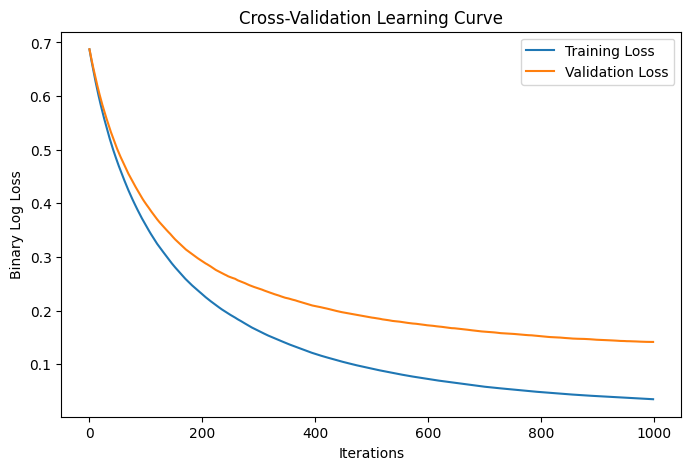

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_params = {
    'learning_rate': 0.012,
    'num_leaves': 7,
    'max_depth': 4,
    'lambda_l1': 0.5,
    'lambda_l2': 2.0,
    'min_gain_to_split': 0.085,
    'min_data_in_leaf': 55,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 6,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 42,
    'verbose': -1
}

# Lists to store metrics
train_f1_scores, valid_f1_scores = [], []
train_roc_auc_scores, valid_roc_auc_scores = [], []
train_losses, valid_losses = [], []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n🔄 Fold {fold}/5")

    # Train-validation split for this fold
    X_train, X_valid = X_resampled[train_idx], X_resampled[valid_idx]
    y_train, y_valid = y_resampled[train_idx], y_resampled[valid_idx]

    # Convert to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # Dictionary to store evaluation results
    evals_result = {}

    # Train LightGBM Model with Early Stopping
    model = lgb.train(
        best_params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'validation'],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=30, verbose=True),
            lgb.record_evaluation(evals_result)  # Store loss values
        ]
    )

    # Predictions
    y_train_pred = (model.predict(X_train) >= 0.5).astype(int)
    y_valid_pred = (model.predict(X_valid) >= 0.5).astype(int)

    # Probabilities for ROC-AUC
    y_train_proba = model.predict(X_train)
    y_valid_proba = model.predict(X_valid)

    # Compute Scores
    train_f1_scores.append(f1_score(y_train, y_train_pred))
    valid_f1_scores.append(f1_score(y_valid, y_valid_pred))

    train_roc_auc_scores.append(roc_auc_score(y_train, y_train_proba))
    valid_roc_auc_scores.append(roc_auc_score(y_valid, y_valid_proba))

    # Store Log Loss for Learning Curve
    train_losses.append(evals_result['train']['binary_logloss'])
    valid_losses.append(evals_result['validation']['binary_logloss'])

# Compute mean loss across folds
min_length = min(len(loss) for loss in train_losses)
mean_train_loss = np.mean([loss[:min_length] for loss in train_losses], axis=0)
mean_valid_loss = np.mean([loss[:min_length] for loss in valid_losses], axis=0)

# Print Average Performance
print("\n📊 Average Model Performance Across Folds:")
print(f"Training F1 Score: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
print(f"Validation F1 Score: {np.mean(valid_f1_scores):.4f} ± {np.std(valid_f1_scores):.4f}")
print(f"Training ROC-AUC Score: {np.mean(train_roc_auc_scores):.4f} ± {np.std(train_roc_auc_scores):.4f}")
print(f"Validation ROC-AUC Score: {np.mean(valid_roc_auc_scores):.4f} ± {np.std(valid_roc_auc_scores):.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(mean_train_loss, label='Training Loss')
plt.plot(mean_valid_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Binary Log Loss')
plt.title('Cross-Validation Learning Curve')
plt.legend()
plt.show()

Loaded audio shape: (144888,), Sample Rate: 22050


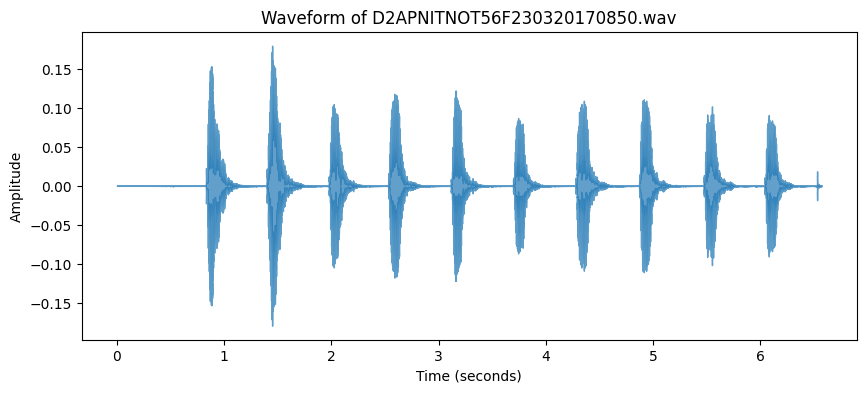

Original MFCC shape: (13, 283)
Padded/Truncated MFCC shape: (13, 100)
Flattened MFCC shape: (1300,)
Healthy


In [ ]:
def predict_audio(file_path):
    mfcc_features = extract_mfcc(file_path)  # Shape: (1300,)

    if mfcc_features is None:
        return "Error: Unable to extract features"

    # Reshape to match the model input
    mfcc_features = mfcc_features.reshape(1, -1)  # Adding batch dimension

    prediction = model.predict(mfcc_features)  # Now it should return a 2D array

    return "Parkinson’s" if prediction[0] > 0.5 else "Healthy"

# Example usage:
file_to_predict = "/content/D2APNITNOT56F230320170850.wav"
print(predict_audio(file_to_predict))

Loaded audio shape: (1620896,), Sample Rate: 22050


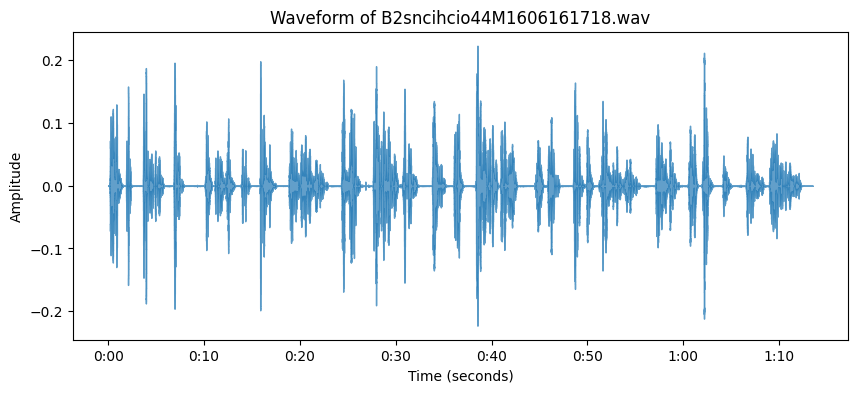

Original MFCC shape: (13, 3166)
Padded/Truncated MFCC shape: (13, 100)
Flattened MFCC shape: (1300,)
Parkinson’s


In [ ]:
file_to_predict = "/content/B2sncihcio44M1606161718.wav"
print(predict_audio(file_to_predict))